In [ ]:
## Mounting the google drive to access required project files
from google.colab import drive
drive.mount('/content/drive/')

## Defining Path for Project files on google drive
project_path = "/content/drive/My Drive/Datasets/Fake News Challenge/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
## Loading the Glove Embeddings
from zipfile import ZipFile
with ZipFile(project_path+'glove.6B.zip', 'r') as z:
  z.extractall()

In [ ]:
## Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from nltk.tokenize import sent_tokenize
from keras.preprocessing.text import text_to_word_sequence
#from keras.preprocessing import sequence
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
import keras
from sklearn.model_selection import train_test_split
#import re

In [ ]:
##Loading the dataset

train_bodies_df = pd.read_csv("/content/drive/My Drive/Datasets/Fake News Challenge/train_bodies.csv")
train_stances_df = pd.read_csv("/content/drive/My Drive/Datasets/Fake News Challenge/train_stances.csv")
dataset = pd.merge(train_bodies_df,train_stances_df,on='Body ID') #Saving the final merged dataset in a dataframe with name dataset.
##len(train_bodies_df), len(train_stances_df), len(dataset)
print("Dataset Shape: ",dataset.shape)

Dataset Shape:  (49972, 4)


In [ ]:
dataset.head()
#dataset.tail()

,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated


In [ ]:
dataset['Stance'].value_counts()

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64

In [ ]:
## MAX_NB_WORDS = Maximum no.of words in the total vocabualry.
MAX_NB_WORDS = 20000

## MAX_SENTS = Maximum no.of sentences to consider in an article.
MAX_SENTS = 20

## MAX_SENTS_HEADING = Maximum no.of sentences to consider in a heading of an article.
MAX_SENTS_HEADING = 1

## MAX_SENT_LENGTH = Maximum no.of words to consider in a sentence.
MAX_SENT_LENGTH = 20

VALIDATION_SPLIT = 0.2


In [ ]:
## Downloading the package punkt from nltk. This is for sentence tokenization.
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
## Initialize the Tokenizer class with maximum vocabulary count as MAX_NB_WORDS 
t1 = Tokenizer(num_words=MAX_NB_WORDS)
#Now, using fit_on_texts() from Tokenizer class, lets encode the data
#Note: We need to fit articleBody and Headline also to cover all the words.
t1.fit_on_texts(dataset['articleBody'].values)

#print("\nWord Count :\n",t1.word_counts)
#print("\nWord Docs :\n",t1.word_docs)
print("\nWord Index :\n",t1.word_index)
print("\nDocument Count :\n",t1.document_count)


word_index1 = t1.word_index
print('Found %s unique tokens.' % len(word_index1))



Word Index :
 {'the': 1, 'to': 2, 'a': 3, 'of': 4, 'in': 5, 'and': 6, 'that': 7, 'is': 8, 'was': 9, 'on': 10, 'for': 11, 'said': 12, 'he': 13, 'with': 14, 'it': 15, 'his': 16, 'have': 17, 'as': 18, 'by': 19, 'has': 20, 'from': 21, 'at': 22, 'be': 23, 'an': 24, 'not': 25, 'are': 26, 'been': 27, '”': 28, 'but': 29, 'this': 30, 'had': 31, 'who': 32, 'they': 33, 'after': 34, 'i': 35, 'were': 36, 'we': 37, 'will': 38, 'about': 39, 'one': 40, 'or': 41, 'which': 42, 'she': 43, 'video': 44, 'apple': 45, 'up': 46, 'would': 47, 'her': 48, 'state': 49, 'their': 50, 'also': 51, 'more': 52, 'when': 53, 'told': 54, 'out': 55, 'isis': 56, 'all': 57, 'no': 58, 'new': 59, 'people': 60, 'there': 61, 'you': 62, 'its': 63, 'if': 64, 'him': 65, 'news': 66, 'what': 67, 'could': 68, 'man': 69, 'year': 70, 'islamic': 71, 'time': 72, 'some': 73, 'al': 74, 'according': 75, 'watch': 76, 'over': 77, 'group': 78, 'into': 79, 'so': 80, 'first': 81, 'last': 82, 'being': 83, 'just': 84, 'u': 85, 's': 86, '—': 87, 'g

In [ ]:
t2 = Tokenizer(num_words=MAX_NB_WORDS)
t2.fit_on_texts(dataset['Headline'].values)

#print("\nWord Count :\n",t2.word_counts)
#print("\nWord Docs :\n",t2.word_docs)
print("\nWord Index :\n",t2.word_index)
print("\nDocument Count :\n",t2.document_count)


word_index2 = t2.word_index
print('Found %s unique tokens.' % len(word_index2))



Word Index :
 {'in': 1, 'to': 2, 'of': 3, 'isis': 4, 'the': 5, 'a': 6, 'is': 7, 'on': 8, 'for': 9, 'and': 10, 'by': 11, 'at': 12, 'after': 13, 'with': 14, 'foley': 15, 'james': 16, 'video': 17, 'journalist': 18, 'michael': 19, 'as': 20, 'says': 21, 'islamic': 22, 'state': 23, 'boko': 24, 'not': 25, 'haram': 26, 'was': 27, 'brown': 28, 'apple': 29, 'have': 30, 'claims': 31, 'audio': 32, 'american': 33, 'kim': 34, 'ebola': 35, 'his': 36, 'has': 37, 'us': 38, 'jong': 39, 'who': 40, 'u': 41, 's': 42, 'man': 43, 'from': 44, 'watch': 45, 'report': 46, 'new': 47, 'it': 48, 'reportedly': 49, 'missing': 50, 'steve': 51, 'reports': 52, 'shooting': 53, 'militants': 54, 'kidnapped': 55, 'that': 56, 'leader': 57, 'jobs': 58, 'killed': 59, 'wright': 60, 'dead': 61, 'fighters': 62, 'are': 63, 'be': 64, 'woman': 65, 'hoax': 66, 'shot': 67, 'girls': 68, 'meteorite': 69, 'alleged': 70, 'been': 71, 'up': 72, 'off': 73, 'ceasefire': 74, 'he': 75, 'beheading': 76, 'christian': 77, 'beheads': 78, 'no': 79,

In [ ]:
#Tokenize the sentences using nltk sent_tokenize() and encode the senteces with the ids we got form the above t.word_index
#Initializing 2 lists with names texts and articles and also for headings
texts = dataset['articleBody'] ##to store text of article as it is
articles = texts.apply(sent_tokenize) #split the above text into a list of sentences.
texts_heading = dataset['Headline'] ##to store headings of article as it is
articles_heading = texts_heading.apply(sent_tokenize) #split the article heading into a list of sentences.

In [ ]:
texts[0]

'A small meteorite crashed into a wooded area in Nicaragua\'s capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city\'s airport, the Associated Press reports. \n\nGovernment spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a "relatively small" meteorite that "appears to have come off an asteroid that was passing close to Earth." House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. \nMurillo said Nicaragua will ask international experts to help local scientists in understanding what happened.\n\nThe crater left by the meteorite had a radius of 39 feet and a depth of 16 feet,  said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee. He said it is still not clear if the meteorite disintegrated or was buried.\n\nHumbe

In [ ]:
## Accessing first element of articles
articles[0]

["A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday.",
 "Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports.",
 'Government spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a "relatively small" meteorite that "appears to have come off an asteroid that was passing close to Earth."',
 'House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports.',
 'Murillo said Nicaragua will ask international experts to help local scientists in understanding what happened.',
 'The crater left by the meteorite had a radius of 39 feet and a depth of 16 feet,  said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee.',
 'He said it is still not clear if the meteorite disintegrated or was bu

In [ ]:
texts_heading[0]

'Soldier shot, Parliament locked down after gunfire erupts at war memorial'

In [ ]:
articles_heading[0]

['Soldier shot, Parliament locked down after gunfire erupts at war memorial']

In [ ]:
##   Funtion to update numpy np.zeros by iterating through the words and sentences in each article.
##    encoding the words into ids using t.word_index 

def encodeWord2Index(npData,textList,word_index):
  for artl_ind in range(npData.shape[0]):
    sentCnt = len(articles[artl_ind])
    if sentCnt > npData.shape[1] :
      sentCnt = npData.shape[1]
    for sent_ind in range(sentCnt):
      word_seq = text_to_word_sequence(textList[artl_ind][sent_ind])
      wordCnt = len(word_seq)
      if wordCnt > npData.shape[2] :
        wordCnt = npData.shape[2]
      for word_ind in range(wordCnt):
        word_ind_val = word_index.get(word_seq[word_ind])
        if word_ind_val is not None:
          npData[artl_ind][sent_ind][word_ind] = word_ind_val
  return npData

In [ ]:
##Initialize a variable of shape (no.of articles, MAX_SENTS, MAX_SENT_LENGTH) with name data
## with zeros first (we can use numpy np.zeros to initialize with all zeros)

data = np.zeros( (t1.document_count,MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
data = encodeWord2Index(data,articles,word_index1)

data_heading = np.zeros( (t2.document_count,MAX_SENTS_HEADING, MAX_SENT_LENGTH), dtype='int32')
data_heading = encodeWord2Index(data_heading,articles_heading,word_index2)


In [ ]:
print("Article Body data Shape : ",data.shape,"\nHeading data_heading Shape : ",data_heading.shape)

Article Body data Shape :  (49972, 20, 20) 
Heading data_heading Shape :  (49972, 1, 20)


In [ ]:
## Concatenate article body and heading array
totData=np.concatenate([data_heading,data],axis=1)

In [ ]:
## Accessing first element of concatenated data [ Heading & Body ]
totData[1, :, :]

array([[ 1034,  2405,  2406,  2407,    13,    87,   458,   119,   147,
            9,   256,     0,     0,     0,     0,     0,     0,     0,
            0,     0],
       [    3,   500,   532,  7117,    79,     3,  3664,   318,     5,
         4576,   369,     4,  1668,  2886,     1,    88,    12,   444,
            0,     0],
       [  727,    94,  1032,     3,  2963,  1778,     7,   171,     3,
         1223,  1095,  2062,   779,   154,     1,  2959,   471,     1,
          533,   227],
       [   88,  1033,  4027,  2275,    12,     3,  1052,  3220,    19,
            1,    88,     2,  1725,     1,   514,  1956,    15,     9,
            3,  3035],
       [  174,  3773,   980,   191,  2487,    42,  6689,  1665,  1210,
            5, 13146, 17648,     1,   751,    30,   712,  3901,    66,
           92,     0],
       [ 2275,    12,  2316,    38,  1058,   337,   816,     2,   359,
          255,  1796,     5,  4371,    67,   478,     0,     0,     0,
            0,     0],
       [  

In [ ]:
## Accessing first element of data_heading
data_heading[1, :, :]

array([[1034, 2405, 2406, 2407,   13,   87,  458,  119,  147,    9,  256,
           0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int32)

In [ ]:
## Accessing first element in data
data[1, :, :]

array([[    3,   500,   532,  7117,    79,     3,  3664,   318,     5,
         4576,   369,     4,  1668,  2886,     1,    88,    12,   444,
            0,     0],
       [  727,    94,  1032,     3,  2963,  1778,     7,   171,     3,
         1223,  1095,  2062,   779,   154,     1,  2959,   471,     1,
          533,   227],
       [   88,  1033,  4027,  2275,    12,     3,  1052,  3220,    19,
            1,    88,     2,  1725,     1,   514,  1956,    15,     9,
            3,  3035],
       [  174,  3773,   980,   191,  2487,    42,  6689,  1665,  1210,
            5, 13146, 17648,     1,   751,    30,   712,  3901,    66,
           92,     0],
       [ 2275,    12,  2316,    38,  1058,   337,   816,     2,   359,
          255,  1796,     5,  4371,    67,   478,     0,     0,     0,
            0,     0],
       [    1,   779,   171,    19,     1,   532,    31,     3,  7312,
            4,  2099,  1210,     6,     3,  5172,     4,  1223,  1210,
           12,  3280],
       [  

In [ ]:
'''Converting  labels into one-hot vectors
Used get_dummies in pandas to create one-hot vectors.'''
labels=pd.get_dummies(dataset['Stance']).values
labels

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]], dtype=uint8)

In [ ]:
print('Shape of data tensor:', totData.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (49972, 21, 20)
Shape of label tensor: (49972, 4)


In [ ]:
## get numbers upto no.of articles
indices = np.arange(totData.shape[0])
## shuffle the numbers
np.random.shuffle(indices)

In [ ]:
## shuffle the data
totData = totData[indices]
## shuffle the labels according to data
labels = labels[indices]

In [ ]:
'''Split into train and validation sets. Split the train set 80:20 ratio to get the train and validation sets.
Use the variable names as given below:

x_train, x_val - for body of articles.

y_train - for training labels.

y_val - for validation labels.'''

x_train, x_val, y_train, y_val = train_test_split(totData, labels, test_size=VALIDATION_SPLIT, random_state=1000)

print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)


(39977, 21, 20)
(39977, 4)
(9995, 21, 20)
(9995, 4)


In [ ]:
## Creating embedding_matrix which has all the words and their glove embedding if present in glove word list.
## load the whole embedding into memory
embeddings_index = dict()
f = open('./glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
# create a weight matrix for words in training docs
## This creates a matrix where the $i$th row gives the word embedding for the word represented by integer $i$.
## Essentially, these will be the "weights" for the Embedding Layer
## Rather than learning the weights, we will use these ones and "freeze" the layer


word_index2.update(word_index1)
embedding_matrix = np.zeros((len(word_index2), 100))

for word, i in word_index2.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
 

In [ ]:
embedding_matrix.shape

(27873, 100)

In [ ]:
#LSTM Model Creation
word_dimension = 100  # This is the dimension of the words we are using from GloVe
input_length=x_train.shape[1]*x_train.shape[2] ## 21 * 20 = 420
model = Sequential()
model.add(Embedding(len(word_index2),
                            word_dimension,  
                            weights=[embedding_matrix],  # We set the weights to be the word vectors from GloVe
                            input_length=input_length,
                            trainable=False))  # By setting trainable to False, we "freeze" the word embeddings.
model.add(LSTM(20, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 420, 100)          2787300   
_________________________________________________________________
lstm_6 (LSTM)                (None, 20)                9680      
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 84        
Total params: 2,797,064
Trainable params: 9,764
Non-trainable params: 2,787,300
_________________________________________________________________


In [ ]:
rmsprop = keras.optimizers.RMSprop(lr = .002)

model.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

In [ ]:
x_train = x_train.reshape(x_train.shape[0], input_length)
x_val = x_val.reshape(x_val.shape[0], input_length)
x_train.shape  

(39977, 420)

In [ ]:
##can take epoch = 20 for more accuracy , but it takes time
batch_size = 128
#epochs = 20
epochs = 2

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val))

Train on 39977 samples, validate on 9995 samples
Epoch 1/2
39977/39977 [==============================] - 221s 6ms/step - loss: 0.8030 - acc: 0.7310 - val_loss: 0.7927 - val_acc: 0.7276
Epoch 2/2
39977/39977 [==============================] - 217s 5ms/step - loss: 0.7780 - acc: 0.7345 - val_loss: 0.7793 - val_acc: 0.7306


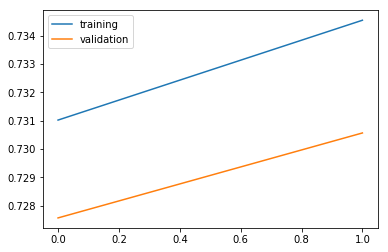

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()